In [1]:
#@title Imports and function definitions

import os


# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

import imagesize

In [2]:
# adds scripts/ and src/ folder: so you can import scripts/functions across project steps
import sys 
sys.path.append("../../src")
sys.path.append("../../scripts")

from os import listdir
from os import path

import pandas as pd
from tqdm.notebook import tqdm

from data_filepaths import image_folders, portraits_csv, images_with_boxes_folder, object_detection_results_csv_path


In [3]:
portraits = pd.read_csv(portraits_csv)
portraits.head()

,Unnamed: 0,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename,correcteddate
0,101881,Masaccio,1420.0,self-portrait,338.0,480.0,18747.0,wikiart,Early Renaissance,Self portait,train_only,True,85505.jpg,1420.0
1,20989,Masaccio,1425.0,portrait,999.0,1300.0,899549.0,wikiart,Early Renaissance,Portrait of a Young Woman,train_only,True,80100.jpg,1425.0
2,70345,Masaccio,1425.0,portrait,548.0,800.0,116190.0,wikiart,Early Renaissance,Portrait of a Young Man,train_only,True,34161.jpg,1425.0
3,12749,Robert Campin,1430.0,portrait,1256.0,1857.0,219654.0,wikiart,Northern Renaissance,Portrait of a Woman,test_only,False,85550.jpg,1430.0
4,2904,Robert Campin,1430.0,portrait,2024.0,3019.0,416418.0,wikiart,Northern Renaissance,Portrait of a Man,test_only,False,2662.jpg,1430.0


In [4]:
image_folder = image_folders[0]
train0 = listdir(image_folder)
train0 = train0#[0:10] # SMALL SELECTION

image_paths = pd.DataFrame({
    "new_filename":train0,
    "path": [path.join(image_folder, n) for n in train0]
})

image_paths

,new_filename,path
0,93571.jpg,../../data/kaggle_painters_by_numbers/train/93...
1,90123.jpg,../../data/kaggle_painters_by_numbers/train/90...
2,71660.jpg,../../data/kaggle_painters_by_numbers/train/71...
3,11898.jpg,../../data/kaggle_painters_by_numbers/train/11...
4,73354.jpg,../../data/kaggle_painters_by_numbers/train/73...
...,...,...
79428,46349.jpg,../../data/kaggle_painters_by_numbers/train/46...
79429,10051.jpg,../../data/kaggle_painters_by_numbers/train/10...
79430,12831.jpg,../../data/kaggle_painters_by_numbers/train/12...
79431,12678.jpg,../../data/kaggle_painters_by_numbers/train/12...


In [5]:
portraits_path = image_paths.merge(portraits, on = 'new_filename', how = 'inner')
portraits_path.head()

,new_filename,path,Unnamed: 0,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,correcteddate
0,50598.jpg,../../data/kaggle_painters_by_numbers/train/50...,9661,Eugene Delacroix,1854.0,portrait,1482.0,2016.0,1661954.0,wikiart,Romanticism,Woman from Algiers with Windhund,train_and_test,True,1854.0
1,34342.jpg,../../data/kaggle_painters_by_numbers/train/34...,76576,Max Liebermann,NaN,self-portrait,546.0,680.0,71611.0,wikiart,Impressionism,Self-Portrait with Palette,train_and_test,True,NaN
2,70677.jpg,../../data/kaggle_painters_by_numbers/train/70...,71362,Robert Julian Onderdonk,1902.0,portrait,535.0,800.0,494998.0,wikiart,Impressionism,Portrait of Gertrude,train_and_test,True,1902.0
3,80854.jpg,../../data/kaggle_painters_by_numbers/train/80...,88960,Hans von Aachen,1574.0,self-portrait,423.0,600.0,74147.0,wikiart,Mannerism (Late Renaissance),Self-portrait,train_and_test,True,1574.0
4,44938.jpg,../../data/kaggle_painters_by_numbers/train/44...,9702,Henri Rousseau,1891.0,portrait,1539.0,1936.0,272019.0,wikiart,Naïve Art (Primitivism),Portrait of Pierre Loti,train_and_test,True,1891.0


In [9]:
portraits_path_b1800 = portraits_path[portraits_path.correcteddate<1800]

In [10]:
pil_image = Image.open(portraits_path.path[0])
pil_image.size

(1482, 2016)

In [11]:
#images_sizes = [Image.open(p).size for p in portraits_path.path]
images_sizes = [imagesize.get(p) for p in portraits_path_b1800.path]


In [13]:
images_sizes

2486

In [21]:
pixel_counts = [np.sqrt(w*h) for w,h in images_sizes]

(array([1.709e+03, 3.620e+02, 2.780e+02, 6.500e+01, 4.100e+01, 1.800e+01,
        1.000e+01, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([ 265.51836095, 1082.01969044, 1898.52101992, 2715.02234941,
        3531.5236789 , 4348.02500839, 5164.52633788, 5981.02766737,
        6797.52899686, 7614.03032634, 8430.53165583]),
 <BarContainer object of 10 artists>)

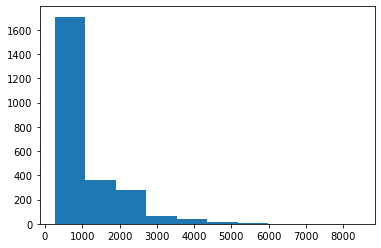

In [22]:
plt.hist(pixel_counts)

In [23]:
pixel_counts

[503.78566871239997,
 519.5469179968254,
 535.5371135598353,
 2195.048974396699,
 1011.2645549014362,
 2260.490875893995,
 514.9757275833493,
 1165.3668950163292,
 464.2197755374064,
 616.3489271508469,
 852.5725775557175,
 609.7540487770458,
 1426.4361184434445,
 846.640419540669,
 906.227344544403,
 842.6149773176359,
 2299.2798872690555,
 736.4781055808787,
 924.6621004453465,
 2342.4346308915433,
 771.398729581531,
 594.2659337367404,
 389.4226495724151,
 941.2757300600074,
 912.9567350099346,
 720.5553413860729,
 888.1373767610504,
 1151.5207336387825,
 1397.5979393230373,
 961.8497803711347,
 1310.8775686539152,
 463.14144707637644,
 2301.343086112977,
 808.5542653403048,
 666.8957939588463,
 820.1682754166976,
 1759.5453958338217,
 769.135878762654,
 1122.0516922138659,
 987.3955640977936,
 509.11688245431424,
 444.83704881675493,
 2238.6210041005156,
 1708.3325203250097,
 620.4595071396682,
 2412.0530674095876,
 464.1379105395292,
 708.237248385031,
 815.7940916677443,
 499.339

In [24]:
np.floor(np.sqrt(2))

1.0